# Transition Path

In this notebook, I solve and simulate the housing model along a **transition path** stemming from an interest rate shock

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import funcs as f
from scipy import stats

# load the DurableConsumptionModel module
from HousingModel import HousingModelClass

# Set the number of threads in numba
nb.set_num_threads(3)

# Smoother
# from scipy.signal import savgol_filter

In [2]:
# Something for figure layout here
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('axes', axisbelow=True)

# Plot a partial equilibrium transition path

In [275]:
# Initialize model and solve initial steady state
model1 = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})
model1.precompile_numba()
model1.solve()
model1.simulate() # simulate initial ss

# For convenience
par = model1.par
sim = model1.sim
sim1 = model1.sim_path

In [276]:
model1.solve_path()
model1.simulate_path()

In [277]:
# Connect the points
IRF_c_raw = np.zeros(400)
IRF_a_raw = np.zeros(400)
IRF_d_raw = np.zeros(400)
IRF_discrete_raw = np.zeros(400)

# Add ss part
IRF_c_raw[:200] = np.mean(model1.sim.c,axis=1)
IRF_a_raw[:200] = np.mean(model1.sim.a,axis=1)
IRF_d_raw[:200] = np.mean(model1.sim.d,axis=1)
IRF_discrete_raw[:200] = np.mean(model1.sim.discrete,axis=1)

# Add shock part
IRF_c_raw[200:] = np.mean(model1.sim_path.c,axis=1)
IRF_a_raw[200:] = np.mean(model1.sim_path.a,axis=1)
IRF_d_raw[200:] = np.mean(model1.sim_path.d,axis=1)
IRF_discrete_raw[200:] = np.mean(model1.sim_path.discrete,axis=1)

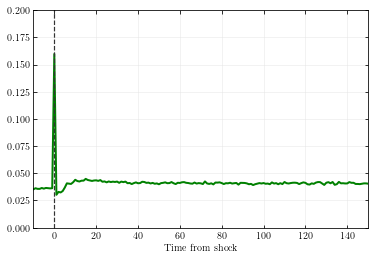

In [282]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(range(-200,200),IRF_discrete_raw, color = 'green', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,150)
ax.set_ylim(0,.2)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_discrete_raw.pdf')

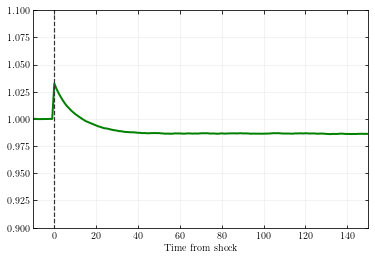

In [279]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(range(-200,200),IRF_c_raw/IRF_c_raw[199], color = 'green', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,150)
ax.set_ylim(.9,1.1)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_c_raw.pdf')

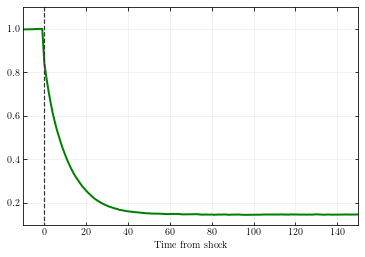

In [280]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(range(-200,200),IRF_a_raw/IRF_a_raw[199], color = 'green', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,150)
ax.set_ylim(.1,1.1)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_a_raw.pdf')

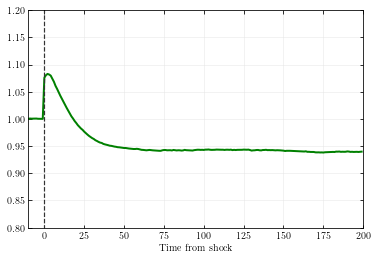

In [281]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(range(-200,200),IRF_d_raw/IRF_d_raw[199], color = 'green', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)

# ax.plot(range(-200,200),IRF_d_raw, color = 'green', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)

ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,200)
ax.set_ylim(.8,1.2)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_d_raw.pdf')

In [ ]:
del model

In [14]:
model2 = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False, 'R':1.02})
model2.precompile_numba()
model2.solve()
model2.simulate() # simulate initial ss

# Find Equilibrium Along a Transition Path

I apply a relaxation algorithm where I use a ghost run along the path as the benchmark to update equilibrium prices

## Baseline Case Without Taxes

### Define model

In [283]:
# Initialize model and solve initial steady state
model1 = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})
model1.precompile_numba()
model1.solve()
model1.simulate() # simulate initial ss

# For convenience
par = model1.par
sim = model1.sim
sim1 = model1.sim_path

### Simulate ghost run

In [284]:
model1.par.R_drop = 0.0
# model1.par.taug = 0.0
model1.solve_path()
model1.simulate_path()
H_ghost1 = np.mean(model1.sim_path.d, axis=1)

Plot ghost run to see how it looks

(0.9, 1.2)

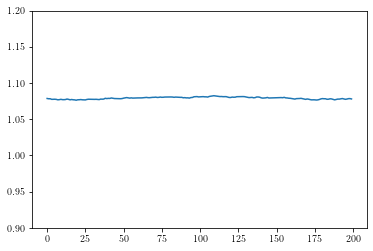

In [285]:
plt.plot(H_ghost1)
plt.ylim(.9,1.2)

### Reset interest rate drop

In [286]:
model1.par.R_drop = 0.01
model1.par.path_ph[:] = 1.0

Check how the partial eq. impulse response looks

### Test the algorithm

In [255]:
model1.solve_path()
model1.simulate_path()

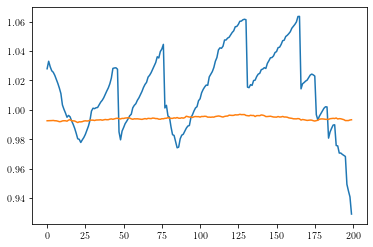

In [256]:
plt.plot(np.mean(model1.sim_path.d,axis=1))
plt.plot(H_ghost1)

In [257]:
H = np.mean(model1.sim_path.d, axis=1)
max_abs_diff = np.max(np.abs(H - H_ghost1))
print(max_abs_diff)

0.06963276684190112


In [258]:
model1.par.path_ph[0:model1.par.path_T] = model1.par.path_ph[0:model1.par.path_T] + .1*(H-H_ghost1)
model1.par.path_ph[model1.par.path_T:] = model1.par.path_ph[model1.par.path_T-1]

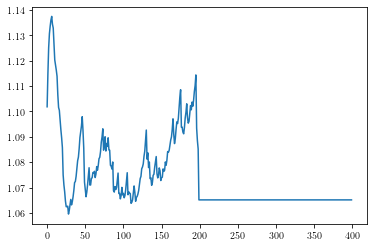

In [259]:
plt.plot(model1.par.path_ph)

### Run algorithm

In [287]:
# a. allocate
# path_ph = np.zeros(par.path_T + par.T)

# b. setting - 0.9999
nu = 0.1 # relaxation parameter
max_iter = 1000 # maximum number of iterations

# # c. Set path of prices
# path_ph[:] = par.ph
model1.par.path_ph[:] = model1.par.ph # Set to steady state

# d. Iterate
it = 0
for _ in range(max_iter):

    # ii. Solve and simulate
    model1.solve_path()
    model1.simulate_path()

    # iii. Implied aggregate housing demand
    H = np.mean(model1.sim_path.d, axis=1)
    
    # iv. Difference
    max_abs_diff = np.max(np.abs(H - H_ghost1)) # remove last 50 periods?
    
    # if it%10 == 0: print(f'{it:4d}: {max_abs_diff:.8f}')
    if max_abs_diff < 10e-4: break # test different values of this threshold

    # v. Update prices
    model1.par.path_ph[0:model1.par.path_T] = model1.par.path_ph[0:model1.par.path_T] + .1*(H-H_ghost1)
    model1.par.path_ph[model1.par.path_T:] = model1.par.path_ph[model1.par.path_T-1]
    
    # path_ph[:model1.par.path_T] =  path_ph[:model1.par.path_T] + nu*(H - H_ghost1) #path_ph[:model1.par.path_T]*(H/H_ghost1**nu)
    # path_ph[model1.par.path_T:] = path_ph[model1.par.path_T-50] # 0.860046773112169 # # Set as equal to the new ss price
    
    # model1.par.path_ph = path_ph
    
    # vi.  Increment
    it += 1
    if it > max_iter: raise Exception('too many iterations')    
    
    print('p_max is ' +str(model1.par.path_ph[0]))
    print(str(it)+'th iteration: dif = '+str(max_abs_diff))

p_max is 1.008134857495715
1th iteration: dif = 0.0892357829857302
p_max is 1.0161493717361476
2th iteration: dif = 0.08838271625862659
p_max is 1.0240739756505626
3th iteration: dif = 0.08957069019411357
p_max is 1.031774492072429
4th iteration: dif = 0.08289732005420358
p_max is 1.0394795777999404
5th iteration: dif = 0.08259926241470872
p_max is 1.047204684404763
6th iteration: dif = 0.083243629076579
p_max is 1.0549295323046388
7th iteration: dif = 0.08113663934961934
p_max is 1.0625364009750884
8th iteration: dif = 0.07755330267085125
p_max is 1.0700269395998439
9th iteration: dif = 0.07543427741938169
p_max is 1.0772420495746988
10th iteration: dif = 0.07248055248401042
p_max is 1.0843832063599612
11th iteration: dif = 0.07286645530709235
p_max is 1.0914586718637262
12th iteration: dif = 0.07360501355832505
p_max is 1.0984159290312416
13th iteration: dif = 0.0727438576101953
p_max is 1.1053127144055255
14th iteration: dif = 0.07331857832719635
p_max is 1.1123440596555179
15th ite

Traceback (most recent call last):
  File "C:\Users\madsh\OneDrive - University of Copenhagen\Desktop\Thesis\code\MA_thesis\HousingModel.py", line 580, in simulate_path
    simulate.monte_carlo(sim_path,sol_path,par,path=True)
KeyboardInterrupt


KeyboardInterrupt: 

### Plot the Impulse Responses

Define path of aggregates, so that it starts 10 periods before the shock

In [288]:
p_path_base = np.zeros(10+model1.par.path_T)
p_path_base[0:10] = model1.par.ph
p_path_base[10:] = model1.par.path_ph[0:model1.par.path_T] / model1.par.ph

c_path_base = np.zeros(10+model1.par.path_T)
c_path_base[0:10] = np.mean(model1.sim.c, axis=1)[-10:] / np.mean(model1.sim.c, axis=1)[-1:]
c_path_base[10:] = np.mean(model1.sim_path.c, axis=1)/ np.mean(model1.sim.c, axis=1)[-1:]

a_path_base = np.zeros(10+model1.par.path_T)
a_path_base[0:10] = np.mean(model1.sim.a, axis=1)[-10:] / np.mean(model1.sim.a, axis=1)[-1:]
a_path_base[10:] = np.mean(model1.sim_path.a, axis=1) / np.mean(model1.sim.a, axis=1)[-1:]

t_axis = range(-10,200) # Time from shock

#### Equilibrium housing price

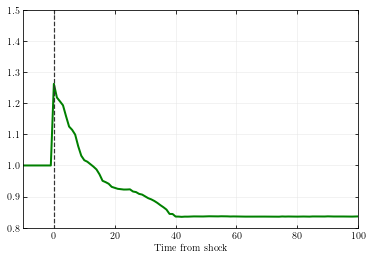

In [303]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, p_path_base, color = 'green', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,100)
# ax.set_ylim(6.98,7.53)
ax.set_ylim(0.8,1.5)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_ph.pdf')

(0.5, 1.5)

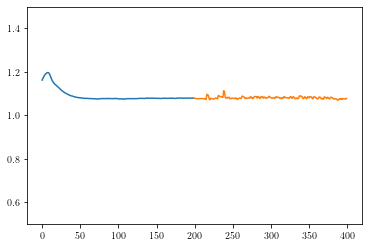

In [311]:
# plt.plot(H_ghost1)
# plt.plot(np.mean(model1.sim_path.d,axis=1))
# plt.plot(np.mean(model1.sim_path.c,axis=1))

plt.plot(range(0,200),np.mean(model1.sim.d,axis=1))
plt.plot(range(200,400),np.mean(model1.sim_path.d,axis=1))

plt.ylim(0.5,1.5)

#### Non-durable consumption

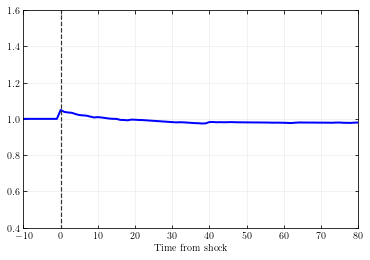

In [308]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, c_path_base, color = 'blue', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,80)
ax.set_ylim(0.4,1.6)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_c.pdf')

#### Cash on hand

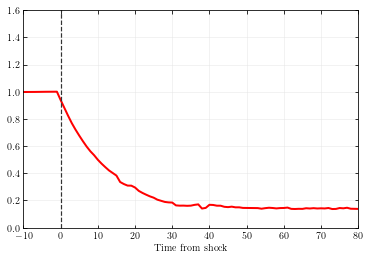

In [309]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, a_path_base, color = 'red', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,80)
ax.set_ylim(0,1.6)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../tex/figs/IRF_m.pdf')

### Compute other statistics along the transition path

Variance of wealth distribution

In [420]:
par1 = model1.par
sim1 = model1.sim
sim_path1 = model1.sim_path

In [426]:
par1.path_T+10

210

In [441]:
# Generate path of wealth
w = np.zeros(shape=(par1.path_T+10,par1.simN))

for k in range(-10,par1.T):
    
    t = k + 10
    if k < 0:
        w[t] = (sim1.m[k] + par1.ph*sim1.n[k]) / sim1.y[k]

    else:
        w[t] = (sim_path1.m[k] + par1.path_ph[k]*sim_path1.n[k]) / sim_path1.y[k]

(-10.0, 200.0)

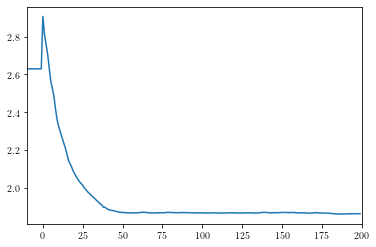

In [442]:
plt.plot(range(-10,200),np.mean(w,axis=1))
plt.xlim(-10,200)

In [443]:
mean_var = np.var(w,axis=1) / np.mean(w,axis=1)

(-10.0, 20.0)

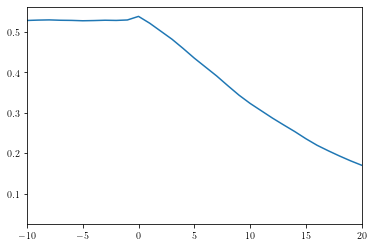

In [444]:
plt.plot(range(-10,200),mean_var)
plt.xlim(-10,20)

In [ ]:
rel_var = np.var(model1.par.path_ph[:200]*model1.sim_path

Binscatter of adjusters

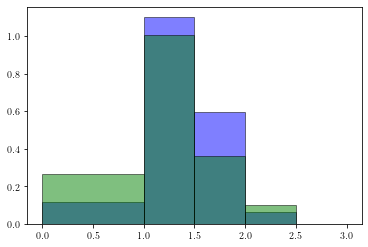

In [384]:
plt.hist(model1.sim_path.n[0,:], model1.par.grid_n, alpha =.5, density = True, color = 'blue', edgecolor = 'k')
plt.hist(model1.sim_path.d[199,:], model1.par.grid_n, alpha =.5, density = True, color = 'green', edgecolor='k')
plt.show()

In [353]:
np.max(model1.sim_path.m[1,:])

13.660167177775335

In [345]:
adj_means, bin_edges, binnumber = stats.binned_statistic(model1.sim_path.m[0,:],model1.sim_path.discrete[9,:], bins = 20, statistic = 'mean')
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

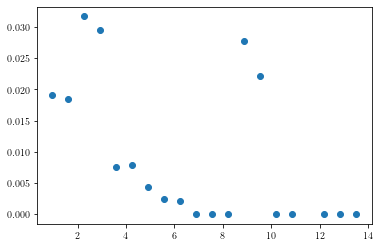

In [346]:
plt.scatter(bin_centers,adj_means)

#### Binned scatterplots

Compute gain from $t=0$ to $t=1$

In [370]:
gain = (par.path_ph[0]*model1.sim_path.n[0,:] - par.ph*model1.sim.d[-1,:]) / model1.sim_path.y[0,:]

# Think about how gain can be computed

In [387]:
# try binned scatterplot
gains_means, bin_edges, binnumber = stats.binned_statistic(model1.sim.m[-1,:],gain, bins=np.linspace(0,10,11), statistic = 'mean')

# Compute bins
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

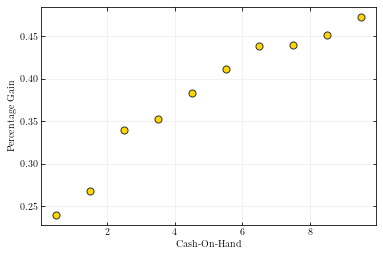

In [388]:
# Initialize the figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.scatter(bin_centers, gains_means, s=50, c='gold', marker='o', edgecolors = '0.2', zorder=2) 
# ax.plot(par.grid_m,y_fit)

# Plot setting
ax.set_xlabel('Cash-On-Hand')
ax.set_ylabel('Percentage Gain')

# ax.set_xlim(0,200)
# ax.set_ylim(0.4,.55)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend()

plt.savefig('../../tex/figs/gains_bins.pdf')

Housing demand

In [391]:
# try binned scatterplot
n_init, bin_edges, binnumber = stats.binned_statistic(model1.sim.m[-1,:],model1.sim_path.n[0,:], bins=np.linspace(0,10,11), statistic = 'mean')

# Compute bins
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_init = bin_edges[1:] - bin_width/2

In [410]:
# try binned scatterplot
n_term, bin_edges, binnumber = stats.binned_statistic(model1.sim_path.m[150,:],model1.sim_path.n[150,:], bins=np.linspace(0,10,11), statistic = 'mean')

# Compute bins
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_term = bin_edges[1:] - bin_width/2

In [411]:
n_term

array([0.91395622, 1.30591642, 1.99045444,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

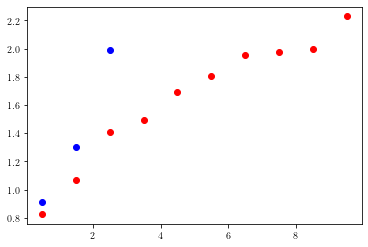

In [412]:
plt.scatter(bin_centers_init,n_init, color = 'red')
plt.scatter(bin_centers_term,n_term, color = 'blue')

# Transition path with avancebeskatning

Define model

In [2]:
# Set parameters
taug = 0.2 # Avancebeskatnings rate
Npb = 50

# Initialize model and solve initial steady state
model2 = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'taug':taug, 'Npb':Npb, 'do_print':False})
model2.precompile_numba()
model2.solve()
model2.simulate() # simulate initial ss

# Extract model for convenience
par = model2.par
sim = model2.sim
sim_path = model2.sim_path

Set parameter values and simulate ghost run

In [3]:
# Remove interest rate drop
model2.par.R_drop = 0.0

# Solve and simulate
model2.solve_path()
model2.simulate_path()
H_ghost2 = np.mean(model2.sim_path.d, axis=1)

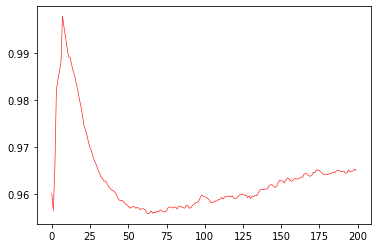

In [4]:
plt.plot(H_ghost2, color = 'red', linestyle = '-', linewidth = .6, alpha =1)
# plt.plot(H_ghost1, color = 'blue', linestyle = '-', linewidth = .6, alpha =1)

Reset interest rate drop

In [5]:
model2.par.R_drop = 0.01

In [6]:
# a. allocate
path_ph = np.zeros(model2.par.path_T + model2.par.T)

# b. setting - 0.9999
nu = .1 # relaxation parameter
max_iter = 1000 # maximum number of iterations

# # c. Set path of prices
path_ph[:] = model2.par.ph
model2.par.path_ph = path_ph

# d. iterate
it = 0
for _ in range(max_iter):

    # ii. solve and simulate
    model2.solve_path()
    model2.simulate_path()

    # iii. Implied aggregate housing demand
    H = np.mean(model2.sim_path.d, axis=1)
    
    # iv. difference
    max_abs_diff = np.max(np.abs(H[:-50] - H_ghost2[:-50]))
    # if it%10 == 0: print(f'{it:4d}: {max_abs_diff:.8f}')
    if max_abs_diff < 10e-3: break # test different values of this threshold

    # v. update
    path_ph[:model2.par.path_T] = path_ph[:model2.par.path_T] + nu*(H - H_ghost2)
    path_ph[model2.par.path_T:] = path_ph[model2.par.path_T-3]
    
    model2.par.path_ph = path_ph    
    
    # vi.  increment
    it += 1
    if it > max_iter: raise Exception('too many iterations')    
    
    print(str(it)+'th iteration: dif = '+str(max_abs_diff))
    print('p_max is ' +str(path_ph[0]))

1th iteration: dif = 0.062071599068902694
p_max is 1.0029575481094681
2th iteration: dif = 0.05356680199448827
p_max is 1.005868736035879
3th iteration: dif = 0.04630108738483485
p_max is 1.0087265597622508
4th iteration: dif = 0.04305932313644689
p_max is 1.0115675319582318
5th iteration: dif = 0.04307330340490123
p_max is 1.014403077427455
6th iteration: dif = 0.07825122280361918
p_max is 1.0172172766242022
7th iteration: dif = 0.06484253517595895
p_max is 1.0200684054286453
8th iteration: dif = 0.058996819989596494
p_max is 1.0229325123252135
9th iteration: dif = 0.05197701549772216
p_max is 1.0257956333943077
10th iteration: dif = 0.05129270529524721
p_max is 1.0286042323352511
11th iteration: dif = 0.05534680585549023
p_max is 1.031685839165876
12th iteration: dif = 0.07942888789312896
p_max is 1.0347294234410258
13th iteration: dif = 0.05030948099166299
p_max is 1.0377576310445364
14th iteration: dif = 0.057797335144808004
p_max is 1.0407620162910567
15th iteration: dif = 0.04753

Traceback (most recent call last):
  File "C:\Users\madsh\OneDrive - University of Copenhagen\Desktop\Thesis\code\MA_thesis\HousingModel.py", line 495, in solve_path
    post_decision.compute_wq(t,R,sol_path,par,ph,compute_q=True)
KeyboardInterrupt


KeyboardInterrupt: 

In [7]:
p_path_g = np.zeros(10+model2.par.path_T)
p_path_g[0:10] = model2.par.ph
p_path_g[10:] = model2.par.path_ph[0:model2.par.path_T] / model2.par.ph

c_path_g = np.zeros(10+model2.par.path_T)
c_path_g[0:10] = np.mean(model2.sim.c, axis=1)[-10:] / np.mean(model2.sim.c[-1])
c_path_g[10:] = np.mean(model2.sim_path.c, axis=1) / np.mean(model2.sim.c[-1])

a_path_g = np.zeros(10+model2.par.path_T)
a_path_g[0:10] = np.mean(model2.sim.a, axis=1)[-10:] / np.mean(model2.sim.a[-1])
a_path_g[10:] = np.mean(model2.sim_path.a, axis=1) / np.mean(model2.sim.a[-1])

t_axis = range(-10,200) # Time from shock

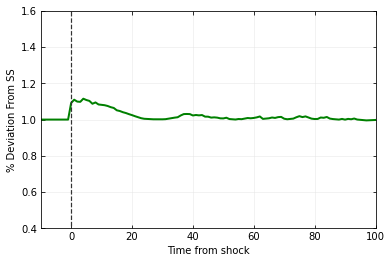

In [8]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, p_path_g, color = 'green', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,100)
ax.set_ylim(0.4,1.6)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../tex/figs/IRF_ph_taug.pdf')

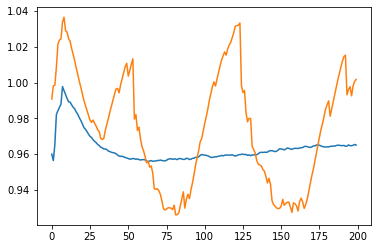

In [452]:
plt.plot(H_ghost2)
plt.plot(np.mean(model2.sim_path.d, axis=1))

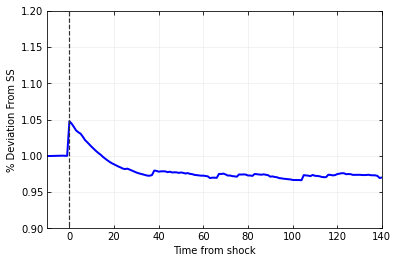

In [9]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, c_path_g, color = 'blue', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,140)
ax.set_ylim(0.9,1.2)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../tex/figs/IRF_c_taug.pdf')

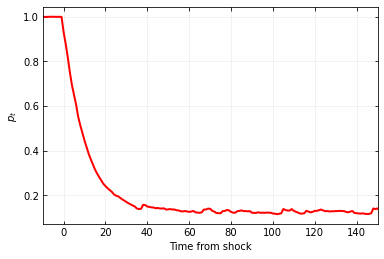

In [10]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, a_path_g, color = 'red', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
# ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,150)
# ax.set_ylim(6.98,7.53)
# ax.set_ylim(0.99,1.02)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'$p_t$')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../tex/figs/IRF_m_taug.pdf')

Plot pb

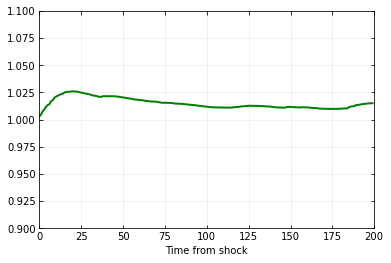

In [12]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis[10:], np.mean(model2.sim_path.pb, axis=1), color = 'green', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
# ax.plot(t_axis[10:], p_path_g[10:], color = 'blue', linestyle='-', linewidth=1,  label = 'Demand',zorder=2)

ax.set_xlim(0,200)
ax.set_ylim(.9,1.1)

ax.set_xlabel('Time from shock')
# ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../tex/figs/IRF_pb_taug.pdf')

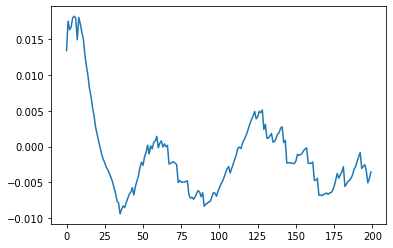

In [482]:
plt.plot(.4*(model2.par.path_ph[:200]-np.mean(model2.sim_path.pb,axis=1)))

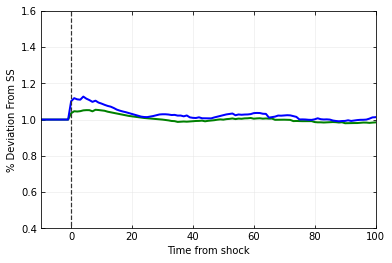

In [480]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, p_path_g, color = 'green', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.plot(t_axis, p_path_base, color = 'blue', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)

ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,100)
ax.set_ylim(0.4,1.6)
 
ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

# plt.savefig('../../tex/figs/IRF_ph_taug.pdf')

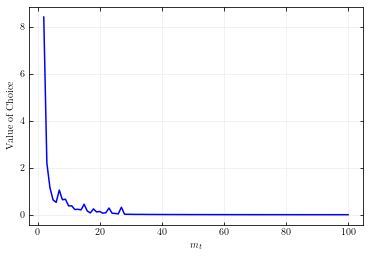

In [88]:
# plt.plot(range(200,0,-1),model1.sol.dist)

# Initialize the figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Plot and scatter
ax.plot(range(100,0,-1),model1.sol.dist[100:], color = 'blue', linewidth = '1.5')

# Plot setting
ax.set_xlabel(r'$m_t$')
ax.set_ylabel('Value of Choice')

# ax.set_xlim(0.7,4.5)
# ax.set_ylim(0.25,2.0)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../tex/figs/dist.pdf')